**Set environment**

In [1]:
suppressWarnings(suppressMessages(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import FCC data

In [2]:
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.screened.fcc.total.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath, show_col_types=FALSE)

dat_peak_atac_fcc_total = dat
print(dim(dat))
head(dat)

[1] 732434      7


Chrom,Start,End,Peak,Score,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
chr1,100006256,100006880,chr1:100006256-100006880,-0.01311792,ASTARR,ASTARR_T
chr1,100010437,100010915,chr1:100010437-100010915,-0.80687947,ASTARR,ASTARR_T
chr1,10002087,10003910,chr1:10002087-10003910,-0.34892859,ASTARR,ASTARR_T
chr1,100021298,100021629,chr1:100021298-100021629,-1.03799571,ASTARR,ASTARR_T
chr1,100023727,100023976,chr1:100023727-100023976,-0.19100207,ASTARR,ASTARR_T
chr1,100027983,100029702,chr1:100027983-100029702,-0.18001582,ASTARR,ASTARR_T


In [3]:
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.summary.ccre_v4.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath, show_col_types=FALSE)

dat_peak_atac_annotation_ccres = dat
print(dim(dat))
head(dat)

[1] 231554      7


Peak,Annotation,Label,Count,Region,Score,Note
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
chr1:10015-10442,ccre_v4,Low-DNase,1,chr1:10033-10250,0,EH38E2776516:Low-DNase
chr1:16015-16477,ccre_v4,Low-DNase,1,chr1:16097-16381,0,EH38E3951272:Low-DNase
chr1:17237-17772,ccre_v4,Low-DNase,1,chr1:17343-17642,0,EH38E3951273:Low-DNase
chr1:28903-29613,ccre_v4,Low-DNase,1,chr1:29320-29517,0,EH38E3951274:Low-DNase
chr1:115411-115986,ccre_v4,CA-CTCF,1,chr1:115562-115912,0,EH38E3951280:CA-CTCF
chr1:118518-118743,ccre_v4,Low-DNase,1,chr1:118508-118826,0,EH38E3951281:Low-DNase


In [21]:
vec = c("PLS", "pELS", "dELS")
dat = dat_peak_atac_annotation_ccres
dat = dat %>% dplyr::filter(Label %in% vec) %>% dplyr::select(Peak, Label)


dat_peak_annot = dat
print(dim(dat))
head(dat)

[1] 39446     2


Peak,Label
<chr>,<chr>
chr1:137737-139544,pELS
chr1:777949-779437,PLS
chr1:826754-828040,PLS
chr1:903633-905556,PLS
chr1:903633-905556,pELS
chr1:923417-925194,PLS


In [71]:
dat = dat_peak_atac_fcc_total
dat = dat %>% 
    dplyr::left_join(dat_peak_annot, by="Peak", relationship="many-to-many") %>%
    dplyr::select(Peak, Score, Assay_Type, Label) %>%
    dplyr::mutate(Label = ifelse(is.na(Label), "None", Label))

dat = dat %>%
    dplyr::group_by(Peak, Score, Assay_Type) %>%
    dplyr::summarize(
        Labels  = paste(Label, collapse=";"),
        .groups = "drop"
    )

dat_peak_score_label = dat
head(dat)

Peak,Score,Assay_Type,Labels
<chr>,<dbl>,<chr>,<chr>
chr10:100009096-100010466,-0.76104829,ASTARR,PLS;pELS
chr10:100009096-100010466,-0.03786170,CRISPRi-Growth,PLS;pELS
chr10:100009096-100010466,0.21052381,WSTARR,PLS;pELS
chr10:100009096-100010466,0.99426000,ENCODE-E2G_Prediction,PLS;pELS
chr10:100020710-100021134,-0.37807380,WSTARR,None
chr10:100020710-100021134,0.06782791,ASTARR,None


In [72]:
fun_bstrap_interveral = function(vec_num, fun = `mean`, num_iteration = 100, num_seed = 123){
    ### init
    set.seed(num_seed)
    
    ### column: num_iteraction
    ### row:    length(vec_num)
    mat = replicate(
        num_iteration,
        sample(vec_num, replace = TRUE)
    )

    vec = apply(mat, 2, fun)
    res = quantile(vec, probs = c(0, 0.025, 0.25, 0.5, 0.75, 0.975, 1))
    res = c(res, mean(vec))
    names(res) = c("Min", "Ci95_Lw", "Q1", "Q2", "Q3", "Ci95_Up", "Max", "Mean")
    return(res)
}

In [73]:
x = c(1,2, 3, 4, 5, 10, 22, 5)
fun_bstrap_interveral(x)

Min   Ci95_Lw        Q1        Q2        Q3   Ci95_Up       Max      Mean 
 2.375000  3.053125  4.843750  6.750000  7.781250 12.262500 13.375000  6.635000

In [75]:
dat = dat_peak_score_label
#dat = dat %>% dplyr::filter(Assay_Type == "CRISPRi-HCRFF")

lst = split(dat, dat$Assay_Type)
lst = lapply(lst, function(dat){
    lst_inner = split(dat$Score, dat$Labels)
    lst_inner = lapply(lst_inner, fun_bstrap_interveral)
    dat = bind_rows(lst_inner, .id = "Labels")
    return(dat)
})
dat = bind_rows(lst, .id = "Assay_Type")
dat_peak_score_summary = dat
head(dat)

Assay_Type,Labels,Min,Ci95_Lw,Q1,Q2,Q3,Ci95_Up,Max,Mean
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASTARR,dELS,0.6387622807,0.6423445479,0.651860575,0.65583784,0.660143202,0.668560307,0.671471742,0.655806862
ASTARR,dELS;pELS,0.4061257440,0.4312265198,0.470377850,0.48980919,0.517453121,0.554390297,0.569966107,0.493551092
ASTARR,None,0.0003368884,0.0005890193,0.002346206,0.00322523,0.004137529,0.005753332,0.006157882,0.003195929
ASTARR,pELS,0.4231806103,0.4240153423,0.443632432,0.45405517,0.465710770,0.477484556,0.485830157,0.454382360
ASTARR,PLS,-0.2426470595,-0.2359484731,-0.210826161,-0.20087265,-0.191396579,-0.172334401,-0.158570600,-0.201905861
ASTARR,PLS;dELS;pELS,0.1069120018,0.1227375144,0.213718311,0.28784558,0.350236901,0.468240495,0.483278680,0.287887632


In [81]:
dat = dat_peak_score_summary
table(dat$Labels)


         dELS     dELS;pELS          None          pELS           PLS 
            8             8             8             8             8 
PLS;dELS;pELS      PLS;pELS 
            7             8 

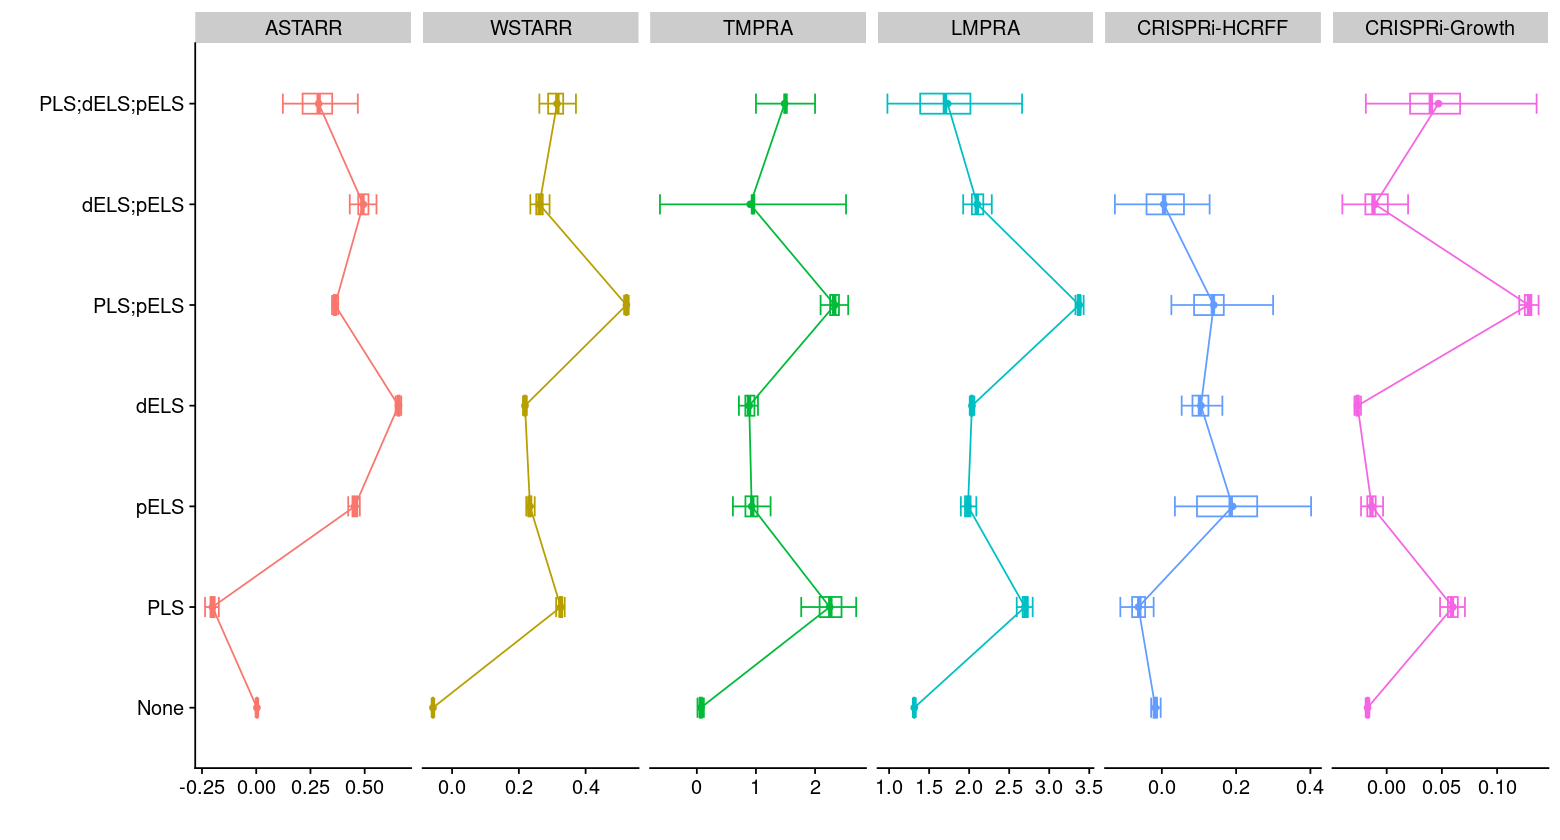

In [93]:
vec_txt_assay = c("ASTARR", "WSTARR", "TMPRA", "LMPRA", "CRISPRi-HCRFF", "CRISPRi-Growth")
vec_txt_label = c("None", "PLS", "pELS", "dELS", "PLS;pELS", "dELS;pELS", "PLS;dELS;pELS")

dat = dat_peak_score_summary
dat = dat %>% 
    dplyr::filter(Assay_Type %in% vec_txt_assay) %>%
    dplyr::mutate(
        Labels = factor(Labels, levels=vec_txt_label),
        Assay_Type = factor(Assay_Type, levels=vec_txt_assay)
    )

gpt = ggplot(dat) + 
    geom_errorbar(
        aes(
            x     = Labels, 
            ymin  = Ci95_Lw, 
            ymax  = Ci95_Up,
            group = Assay_Type, 
            color = Assay_Type
           ), 
        width = 0.2
    ) +
    geom_crossbar(
        aes(
            x     = Labels, 
            y     = Q2,
            ymin  = Q1, 
            ymax  = Q3,
            group = Assay_Type, 
            color = Assay_Type
           ), 
        width = 0.2
    ) +
    geom_line(
        aes(
            x     = Labels, 
            y     = Mean, 
            group = Assay_Type, 
            color = Assay_Type)
    ) +
    geom_point(
        aes(
            x     = Labels, 
            y     = Mean, 
            group = Assay_Type, 
            color = Assay_Type)
    ) +
    labs(x="", y="") +
    theme_cowplot() +
    coord_flip() +
    facet_grid(.~Assay_Type, scales = "free") +
    theme(legend.position = "None")
options(repr.plot.height=7, repr.plot.width = 13)
print(gpt)

In [117]:
dat = dat_peak_score_summary
dat = dat %>% dplyr::select(Assay_Type, Labels, Mean)
tmp = dat %>% 
    dplyr::filter(Labels == "None") %>% 
    tidyr::spread(Labels, Mean)
dat = dat %>% 
    dplyr::left_join(tmp, by="Assay_Type") %>% 
    dplyr::mutate(Diff = Mean - None) %>%
    dplyr::filter(Labels != "None")

dat_peak_score_diff = dat
print(dim(dat))
head(dat)

[1] 47  5


Assay_Type,Labels,Mean,None,Diff
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ASTARR,dELS,0.6558069,0.003195929,0.6526109
ASTARR,dELS;pELS,0.4935511,0.003195929,0.4903552
ASTARR,pELS,0.4543824,0.003195929,0.4511864
ASTARR,PLS,-0.2019059,0.003195929,-0.2051018
ASTARR,PLS;dELS;pELS,0.2878876,0.003195929,0.2846917
ASTARR,PLS;pELS,0.3632690,0.003195929,0.3600731


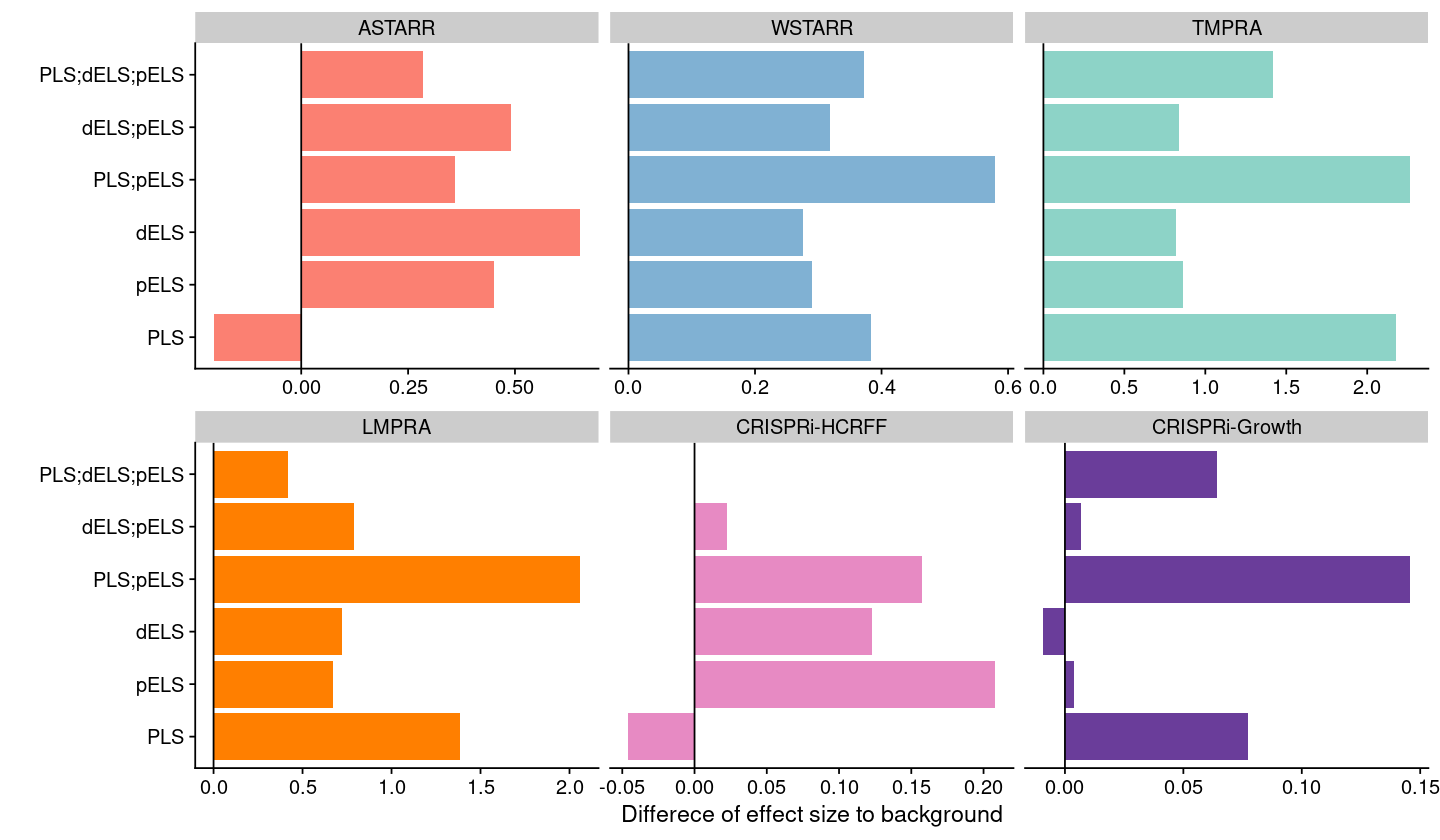

In [137]:
vec_txt_assay = c("ASTARR", "WSTARR", "TMPRA", "LMPRA", "CRISPRi-HCRFF", "CRISPRi-Growth")
vec_txt_label = c("PLS", "pELS", "dELS", "PLS;pELS", "dELS;pELS", "PLS;dELS;pELS")
vec_txt_color = c("ASTARR" = "#fb8072", "WSTARR" = "#80b1d3", "TMPRA" = "#8dd3c7", "LMPRA" = "#ff7f00",
                  "CRISPRi-HCRFF" = "#e78ac3", "CRISPRi-Growth" = "#6a3d9a")
dat = dat_peak_score_diff
dat = dat %>% 
    dplyr::filter(Assay_Type %in% vec_txt_assay) %>%
    dplyr::mutate(
        Labels = factor(Labels, levels=vec_txt_label),
        Assay_Type = factor(Assay_Type, levels=vec_txt_assay)
    )

gpt = ggplot(dat, aes(x=Labels, y=Diff, group = Assay_Type, fill=Assay_Type)) + 
    geom_col(position = "dodge") +
    geom_hline(yintercept = 0) +
    labs(x="", y="Differece of effect size to background") +
    scale_fill_manual(values = vec_txt_color) +
    theme_cowplot() +
    coord_flip() +
    facet_wrap(~Assay_Type, nrow=2, scales = "free_x") +
    theme(legend.position = "None")
options(repr.plot.height=7, repr.plot.width = 12)
print(gpt)
ggsave("fig.fcc_signal.ccres.difference.pdf", gpt, height=7, width=11)
ggsave("fig.fcc_signal.ccres.difference.png", gpt, height=7, width=11, units = "in")

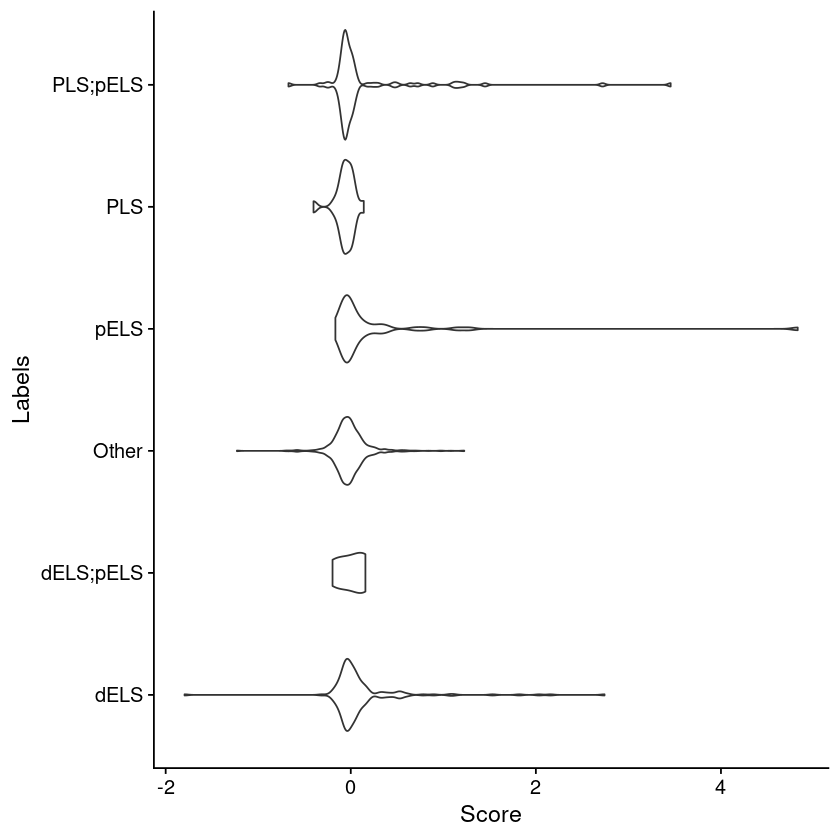

In [23]:
dat = dat_peak_score_label
dat = dat %>% dplyr::filter(Assay_Type == "CRISPRi-HCRFF")
#dat = dat %>% dplyr::filter(Assay_Type %in% c("ASTARR", "CRISPRi-HCRFF"))

gpt = ggplot(dat, aes(x=Labels, y=Score)) + 
    geom_violin() + 
    theme_cowplot() +
    coord_flip()
print(gpt)